In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import dataloader 
from transforms import mulawnEncode,mulaw,array2tensor,dic2tensor
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

In [3]:
# Read/write directory parameters
#*************************************
datadir = 'dataset'
paramdir = 'dataparam'

# Pytorch parameters
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training parameters
#*************************************
sr = 16000
seqLen = 256
stride = 10
batch_size = 25
num_epochs = 1
lr = 0.005
log_interval = 10
max_steps = 201

#Generation parameters
#*************************************
max_length = seqLen*3
evaluate_interval = 25

In [4]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'rmse', 'instID', 'midiPitch'])


In [5]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(256,0,1) #initialize the mu-law encodings
targetcoding = mulaw(256)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID'],  #,'midiPitch'
                                  transform=transform.Compose([audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=dic2tensor(torch.FloatTensor),
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4)

test_loader = torch.utils.data.DataLoader(dataset=adataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
#just for testing

for i in range(len(adataset)):
    sample,target = adataset[i]
    #plt.plot(sample['audio'])
    print(sample)
    #print(target)
    if i == 1:
        break #just to visualize, note: audio is already mu-lawed
        
print(len(adataset))
print(adataset.totalSamples)
#input dim: (batch, seq, feature)

print(sample.shape)

In [7]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden, batch_size=1):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(batch_size,-1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)

In [8]:
# Define the training cycle (100% teacher forcing for now)
#*************************************
def train(epoch):
    rnn.train() #put in training mode
    ave_loss_over_steps = 0
    
    for step, (inp,target) in enumerate(train_loader):
        #print('INP',inp.shape)
        #print("TAR",target.shape)
        inp, target = inp.to(device), target.to(device)

        # Forward + Backward + Optimize
        hidden = rnn.init_hidden(batch_size)
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            outputs, hidden = rnn(inp[:,i,:],hidden,batch_size)  #input dim: (batch, seq, feature)
            loss += criterion(outputs, torch.squeeze(target[:,i],1))
            
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        #print(count,ave_loss)
        
        if (step+1) % log_interval == 0:
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch+1, num_epochs, step+1, len(adataset)//batch_size, ave_loss_over_steps/log_interval))
            
            list_of_losses.append(ave_loss_over_steps/log_interval)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result = generate(max_length)
            plt.figure(figsize=(20,1)) 
            plt.plot(np.arange(len(result)), result) #just print one example from the batch
            plt.show()
        
        if step==max_steps:
            break
        
        
def generate(max_length,primer=None):
    with torch.no_grad():
        if primer is not None:
            p_inp = primer
        else:
            for inp,target in test_loader:
                p_inp = inp
                break
        generated = p_inp[0,:,0].numpy()
        #print(generated)
        p_inp = p_inp.to(device)

        hidden = rnn.init_hidden()
        for j in range(seqLen-1):  #build up hidden state
            _, hidden = rnn(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        
        for i in range(max_length):
            print(inp)
            outputs, hidden = rnn(inp,hidden)
            #print(outputs.shape)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            #print(outputs.detach())
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            #print(topv,topv.shape)
            #print(topi,topi.shape)
            predicted_sample = targetcoding.index2float(topi)
            print(predicted_sample)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.cuda.FloatTensor)
            #print(inp)
            #print(inp.shape)
        
        #print(generated.shape)
        return generated
     
        

In [9]:
# Initialize the network, optimizer and objective func
#*************************************
rnn = RNN(1,1,40,256,4).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

2018-08-15 18:02:20 Starting training...
2018-08-15 18:02:30 Epoch [1/1], Step [10/15200] Loss: 5.3568
2018-08-15 18:02:36 Epoch [1/1], Step [20/15200] Loss: 5.1926
tensor([[ 0.1608,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], de

-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda

tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.0699386160884

tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.0699386160884

-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  0.0000]], device='cuda

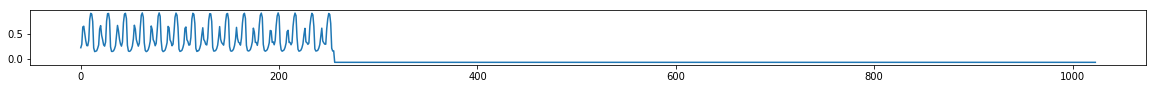

2018-08-15 18:02:46 Epoch [1/1], Step [30/15200] Loss: 5.1853
2018-08-15 18:02:53 Epoch [1/1], Step [40/15200] Loss: 5.1438
2018-08-15 18:02:59 Epoch [1/1], Step [50/15200] Loss: 5.0985
tensor([[ 0.4824,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0

tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 

tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 

0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426

tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 0.8627,  1.0000]], device='cuda:0')
0.21516426892309867
tensor([[ 

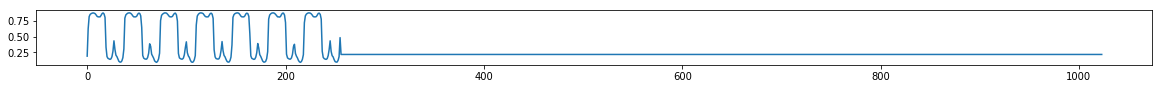

2018-08-15 18:03:09 Epoch [1/1], Step [60/15200] Loss: 5.0807
2018-08-15 18:03:15 Epoch [1/1], Step [70/15200] Loss: 4.9608
tensor([[ 0.9412,  0.0000]], device='cuda:0')
-8.621159565072034e-05
tensor([[ 0.4980,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.05814500388034755
tensor([[ 0.2510,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
ten

-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda

tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.0637855101022

tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.0637855101022

tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.0637855101022

tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.0637855101022

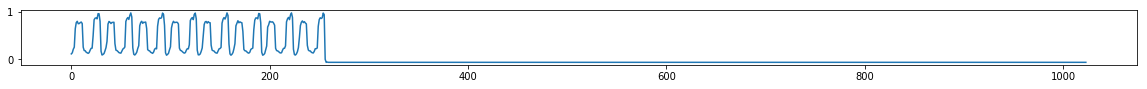

2018-08-15 18:03:24 Epoch [1/1], Step [80/15200] Loss: 4.8058
2018-08-15 18:03:31 Epoch [1/1], Step [90/15200] Loss: 4.5591
2018-08-15 18:03:38 Epoch [1/1], Step [100/15200] Loss: 4.3806
tensor([[ 0.0902,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[

tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.3495740429696

tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.3495740429696

tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.34957404296965766
tensor([[ 0.0941,  1.0000]], device='cuda:0')
-0.3495740429696

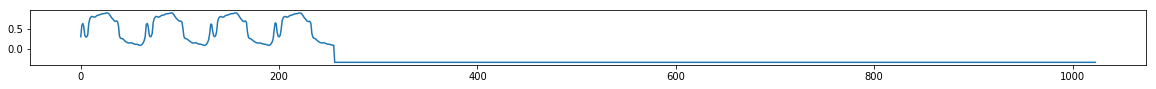

2018-08-15 18:03:47 Epoch [1/1], Step [110/15200] Loss: 4.2516
2018-08-15 18:03:54 Epoch [1/1], Step [120/15200] Loss: 4.1377
tensor([[ 0.2235,  1.0000]], device='cuda:0')
-0.05297439402730209
tensor([[ 0.2588,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.07665090604748023
tensor([[ 0.2275,  1.0000]], device='cuda:0')
-0.11018008942227171
tensor([[ 0.1961,  1.0000]], device='cuda:0')
-0.1648445897488875
tensor([[ 0.1608,  1.0000]], device='cuda:0')
-0.21516426892309853
tensor([[ 0.1373,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tens

tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.2350744231316

-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda

tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.23507442313167584
tensor([[ 0.1294,  1.0000]], device='cuda:0')
-0.2350744231316

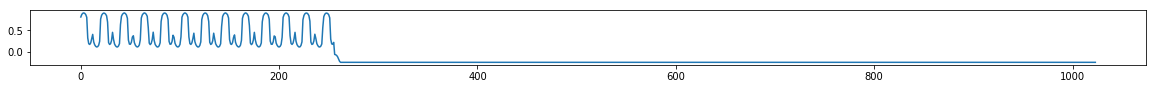

2018-08-15 18:04:03 Epoch [1/1], Step [130/15200] Loss: 3.9750
2018-08-15 18:04:10 Epoch [1/1], Step [140/15200] Loss: 3.9264
2018-08-15 18:04:17 Epoch [1/1], Step [150/15200] Loss: 3.8163
tensor([[ 0.8824,  1.0000]], device='cuda:0')
0.11018008942227171
tensor([[ 0.8039,  1.0000]], device='cuda:0')
-0.046014802627411096
tensor([[ 0.2706,  1.0000]], device='cuda:0')
-0.12608234459462436
tensor([[ 0.1843,  1.0000]], device='cuda:0')
-0.17234644938227578
tensor([[ 0.1569,  1.0000]], device='cuda:0')
-0.21516426892309853
tensor([[ 0.1373,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.2683830998948736
tensor([[ 0.1176,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([

tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.2567939788289

-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda

tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.2567939788289

-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda

-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda:0')
-0.25679397882891775
tensor([[ 0.1216,  1.0000]], device='cuda

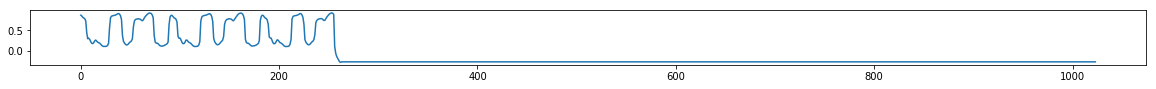

2018-08-15 18:04:26 Epoch [1/1], Step [160/15200] Loss: 3.7833
2018-08-15 18:04:33 Epoch [1/1], Step [170/15200] Loss: 3.7108
tensor([[ 0.1725,  1.0000]], device='cuda:0')
-0.17234644938227578
tensor([[ 0.1569,  1.0000]], device='cuda:0')
-0.1576620046985716
tensor([[ 0.1647,  1.0000]], device='cuda:0')
-0.11525204597363858
tensor([[ 0.1922,  1.0000]], device='cuda:0')
-0.06993861608840268
tensor([[ 0.2353,  1.0000]], device='cuda:0')
-0.04185472929319752
tensor([[ 0.2784,  1.0000]], device='cuda:0')
-0.04185472929319752
tensor([[ 0.2784,  1.0000]], device='cuda:0')
-0.05814500388034755
tensor([[ 0.2510,  1.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.05814500388034755
tensor([[ 0.2510,  1.0000]], device='cuda:0')
-0.05814500388034755
tensor([[ 0.2510,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tens

-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda

-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda

-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda

-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda

-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda:0')
-0.06090393801358016
tensor([[ 0.2471,  1.0000]], device='cuda

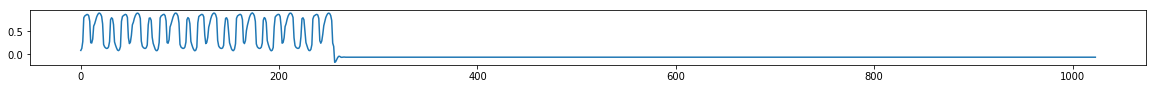

2018-08-15 18:04:42 Epoch [1/1], Step [180/15200] Loss: 3.6736
2018-08-15 18:04:48 Epoch [1/1], Step [190/15200] Loss: 3.6436
2018-08-15 18:04:55 Epoch [1/1], Step [200/15200] Loss: 3.6172
tensor([[ 0.1412,  0.0000]], device='cuda:0')
-0.13186117560059185
tensor([[ 0.1804,  0.0000]], device='cuda:0')
-0.08788022623483743
tensor([[ 0.2157,  0.0000]], device='cuda:0')
-0.06679517155155029
tensor([[ 0.2392,  0.0000]], device='cuda:0')
-0.05814500388034755
tensor([[ 0.2510,  0.0000]], device='cuda:0')
-0.05814500388034755
tensor([[ 0.2510,  0.0000]], device='cuda:0')
-0.06378551010222042
tensor([[ 0.2431,  0.0000]], device='cuda:0')
-0.06679517155155029
tensor([[ 0.2392,  0.0000]], device='cuda:0')
-0.06679517155155029
tensor([[ 0.2392,  0.0000]], device='cuda:0')
-0.06679517155155029
tensor([[ 0.2392,  0.0000]], device='cuda:0')
-0.06679517155155029
tensor([[ 0.2392,  0.0000]], device='cuda:0')
-0.06679517155155029
tensor([[ 0.2392,  0.0000]], device='cuda:0')
-0.06679517155155029
tensor(

tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.0555034883057

tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.0555034883057

tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.0555034883057

tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.0555034883057

-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda:0')
-0.05550348830573362
tensor([[ 0.2549,  0.0000]], device='cuda

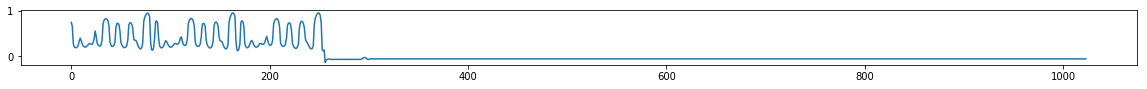

Training time taken: 0:02:38


In [10]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

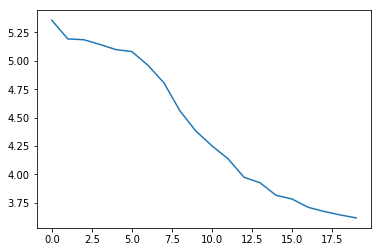

In [11]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)